In [69]:
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc

# Data load & preparation

In the following cells, these actions happen:

- We're loading the data from the CSV file into a pandas `DataFrame`.  This is a data set structure that is extremely popular and quite often used in Python machine learning.

## Data import

In [2]:
original_dataset = pd.read_csv('data/smart-devops.csv')

In [3]:
original_dataset.head(4)

,DefinitionId,DefinitionName,DefinitionQueueStatus,DefinitionType,BuildId,BuildFinishTime,BuildQueueTime,BuildStartTime,BuildResult,BuildStatus,BuildRepositoryType,ChangeSetId,ChangeSetCheckedInBy,ChangeSetCreatedDate,ChangeSetChangeFile,ChangeSetChangeChangeType
0,177,Sgbdnl.Portal,enabled,build,31966,12/20/2019 09:51:47,12/20/2019 09:30:43,12/20/2019 09:46:48,succeeded,completed,TfsGit,1e3f0533f4a473cae0a8f86ff6a749532e091021,Rgvgt Igttkvugp,12/20/2019 09:30:42,GalvanoSendOrderB2BRequestHandlerTests.cs,edit
1,177,Sgbdnl.Portal,enabled,build,30448,11/06/2019 11:51:52,11/06/2019 11:39:45,11/06/2019 11:39:55,succeeded,completed,TfsGit,c1218a2988f8d4086a923398da4f0548b61ea5ea,Rgvgt Igttkvugp,11/06/2019 11:39:44,InvoiceRepositoryTests.cs,edit
2,177,Sgbdnl.Portal,enabled,build,35542,03/24/2020 12:43:40,03/24/2020 12:25:34,03/24/2020 12:43:40,canceled,completed,TfsGit,60d289d4e5bd148fd0490b97f666102d5d437142,Ulqtu xcp Quej,03/24/2020 12:25:33,Sgbdnl.Ebusiness.SalesOrder.Api.csproj,edit
3,177,Sgbdnl.Portal,enabled,build,33474,02/05/2020 11:15:31,02/05/2020 11:13:15,02/05/2020 11:13:18,succeeded,completed,TfsGit,1ca8690ebc1ec53458e5e94aa0783cb2e76c07c5,Lqjcp Qquvgtjqnv,02/05/2020 11:12:23,BannerProfile.cs,edit


In [4]:
original_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212061 entries, 0 to 212060
Data columns (total 16 columns):
DefinitionId                 212061 non-null int64
DefinitionName               212061 non-null object
DefinitionQueueStatus        212061 non-null object
DefinitionType               212061 non-null object
BuildId                      212061 non-null int64
BuildFinishTime              212061 non-null object
BuildQueueTime               212061 non-null object
BuildStartTime               212061 non-null object
BuildResult                  212061 non-null object
BuildStatus                  212061 non-null object
BuildRepositoryType          212061 non-null object
ChangeSetId                  212061 non-null object
ChangeSetCheckedInBy         212061 non-null object
ChangeSetCreatedDate         212061 non-null object
ChangeSetChangeFile          212061 non-null object
ChangeSetChangeChangeType    212061 non-null object
dtypes: int64(2), object(14)
memory usage: 25.9+ MB


In [5]:
original_dataset['BuildFinishTime'] = pd.to_datetime(original_dataset['BuildFinishTime']) 
original_dataset['BuildQueueTime'] = pd.to_datetime(original_dataset['BuildQueueTime']) 
original_dataset['BuildStartTime'] = pd.to_datetime(original_dataset['BuildStartTime']) 


## Data preparation

In the following section, we discuss every feature of the data set and will define what to do with it:

### Definition features

As you can see, the dataset is only providing data for 1 definition, so these features will not be considered in the training model and we can therefore remove it.

__Suggestion__: check if we can rebuild the model, taking into account more definitions.

In [6]:
# This statement just counts the occurrances of different values in a column
dataset = original_dataset.copy()
print(Counter(dataset.DefinitionId))
print(Counter(dataset.DefinitionName))
print(Counter(dataset.DefinitionQueueStatus))
print(Counter(dataset.DefinitionType))

Counter({177: 212061})
Counter({'Sgbdnl.Portal': 212061})
Counter({'enabled': 212061})
Counter({'build': 212061})


In [7]:
# Here we are dropping the column as it's not relevant
# - inplace updates the dataframe
#     alternative would be: dataset = dataset.drop('Column', axis=1)
# -  axis=1 means column (axis=0 means row)
dataset.drop(
    ['DefinitionId', 'DefinitionName', 'DefinitionQueueStatus', 'DefinitionType'], 
    axis=1, inplace=True) 

### Adding changeset specific values

#### Categorizing user values

In [8]:
dataset.ChangeSetCheckedInBy = pd.Categorical(dataset.ChangeSetCheckedInBy)
dataset['user'] = dataset.ChangeSetCheckedInBy.cat.codes

dataset.drop('ChangeSetCheckedInBy', axis=1, inplace=True) 

#### File operations tagging

In [9]:
dataset['changeset_isedit'] = dataset['ChangeSetChangeChangeType'].apply(
    lambda ct: 1 if (ct.lower().find("edit") > -1) else 0)
dataset['changeset_isadd'] = dataset['ChangeSetChangeChangeType'].apply(
    lambda ct: 1 if (ct.lower().find("add") > -1) else 0)
dataset['changeset_isdelete'] = dataset['ChangeSetChangeChangeType'].apply(
    lambda ct: 1 if (ct.lower().find("delete") > -1) else 0)
dataset['changeset_isrename'] = dataset['ChangeSetChangeChangeType'].apply(
    lambda ct: 1 if (ct.lower().find("rename") > -1) else 0)
dataset['changeset_involves_test'] = dataset['ChangeSetChangeFile'].apply(
    lambda ct: 1 if (ct.lower().find("test") > -1) else 0)

In [10]:
def OneHotEncode(df, columnName, drop:bool = False):
    df = pd.concat([df, pd.get_dummies(df[columnName], prefix=columnName)],axis=1, sort=True)
    if(drop): df.drop([columnName], axis=1, inplace=True)
    return df

dataset = OneHotEncode(dataset, 'user')

### Build features

First we verify the BuildResult and BuildStatus fields.  These will be important for our output, as that is what we want to predict, after all.

- The `BuildStatus` feature always has completed as value, so we'll remove it.
- The `BuildResult` feature is the one we need to predict and we will make this a binary classifier, so change all values to 1 for the succeeeded results and 0 for any other result.
- The `BuildRepositoryType` feature indicates if a build was using a Tfs vs Git repo.  This could be interesting information, so we will also encode this feature to a binary type (1 for git, 0 for others)

In [11]:
#print(Counter(dataset.BuildId))
print(Counter(dataset.BuildResult))
print(Counter(dataset.BuildStatus))
print(Counter(dataset.BuildRepositoryType))

Counter({'succeeded': 158716, 'failed': 33484, 'partiallySucceeded': 10540, 'canceled': 9321})
Counter({'completed': 212061})
Counter({'TfsGit': 209281, 'TfsVersionControl': 2780})


#### Drop BuildStatus

In [12]:
# Dropping the BuildStatus feature
dataset.drop('BuildStatus', axis=1, inplace=True) 

#### Encoding (binary classification) of the output feature (BuildResult)

In [13]:
# Applying the encoding of the output feature
dataset['BuildResult'] = dataset['BuildResult'].apply(lambda result: 1 if result == 'succeeded' else 0)

#### Encoding of the repository type

In [14]:
# Applying the encoding of the repository feature
dataset['BuildGitRepo'] = dataset['BuildRepositoryType'].apply(lambda repotype: 1 if (repotype.lower().find("git") > -1) else 0)
dataset.drop('BuildRepositoryType', axis=1, inplace=True) 


In [15]:
dataset.head(5)

,BuildId,BuildFinishTime,BuildQueueTime,BuildStartTime,BuildResult,ChangeSetId,ChangeSetCreatedDate,ChangeSetChangeFile,ChangeSetChangeChangeType,user,...,user_33,user_34,user_35,user_36,user_37,user_38,user_39,user_40,user_41,BuildGitRepo
0,31966,2019-12-20 09:51:47,2019-12-20 09:30:43,2019-12-20 09:46:48,1,1e3f0533f4a473cae0a8f86ff6a749532e091021,12/20/2019 09:30:42,GalvanoSendOrderB2BRequestHandlerTests.cs,edit,28,...,0,0,0,0,0,0,0,0,0,1
1,30448,2019-11-06 11:51:52,2019-11-06 11:39:45,2019-11-06 11:39:55,1,c1218a2988f8d4086a923398da4f0548b61ea5ea,11/06/2019 11:39:44,InvoiceRepositoryTests.cs,edit,28,...,0,0,0,0,0,0,0,0,0,1
2,35542,2020-03-24 12:43:40,2020-03-24 12:25:34,2020-03-24 12:43:40,0,60d289d4e5bd148fd0490b97f666102d5d437142,03/24/2020 12:25:33,Sgbdnl.Ebusiness.SalesOrder.Api.csproj,edit,35,...,0,0,1,0,0,0,0,0,0,1
3,33474,2020-02-05 11:15:31,2020-02-05 11:13:15,2020-02-05 11:13:18,1,1ca8690ebc1ec53458e5e94aa0783cb2e76c07c5,02/05/2020 11:12:23,BannerProfile.cs,edit,15,...,0,0,0,0,0,0,0,0,0,1
4,31738,2019-12-12 09:25:19,2019-12-12 08:57:48,2019-12-12 08:57:56,1,216a06602a8d5912f4dfead6cbc885f0f5bd7550,12/12/2019 08:57:33,sonar-project.properties,edit,19,...,0,0,0,0,0,0,0,0,0,1


### Build timestamps

- We have to convert the timestamps to something meaningful and useful for the model.  We will therefore extract the following relevant information:
  - Build duration
  - DayOfWeek
  - TimeOfDay
  
__Suggestion__: I believe it could be relevant to have the information extracted how long it's been since the user did his/her last build.  


In [16]:
dataset['BuildDuration'] = dataset.apply(lambda row: (row['BuildFinishTime'] - row['BuildStartTime']).total_seconds(), axis=1)
dataset['DayOfWeek'] = dataset.BuildFinishTime.dt.dayofweek
dataset['HourOfDay'] = dataset.BuildFinishTime.dt.hour

In [17]:
dataset.drop(
    ['BuildFinishTime', 'BuildStartTime', 'BuildQueueTime'], 
    axis=1, inplace=True) 

### Build aggregates

The dataset contains multiple records for one build, though we are predicting the actual build.  Therefore, we have to make some groupings, some aggregate logic that could be meaningful.  This is what happens in the next cells:

__Adding new calculations__:

- ChangeSetCount : number of changesets linked to build
- ChangeSetUsersInvolved : number of users involved with changesets for the build
- EditCount : number of edited files
- AddCount : number of added files
- DeleteCount : number of deleted files
- RenameCount : number of renamed files
- TestFileCount : number of test files involved in changesets
- FilesInvolved : number of files involved with changeset


#### Group by BuildId and aggregate dataset

In [18]:
# Showing available data of 1 build
build_counter = Counter(dataset.BuildId)
build_counter.most_common()

# Taking one build that has multiple records linked to it
build_id = 35610

In [19]:
build_df = dataset[dataset.BuildId == build_id]
build_df.head(5)

,BuildId,BuildResult,ChangeSetId,ChangeSetCreatedDate,ChangeSetChangeFile,ChangeSetChangeChangeType,user,changeset_isedit,changeset_isadd,changeset_isdelete,...,user_36,user_37,user_38,user_39,user_40,user_41,BuildGitRepo,BuildDuration,DayOfWeek,HourOfDay
55846,35610,0,373c35370470578235c06fcc4319f7082d15fe27,03/25/2020 09:32:10,app.module.ts,edit,17,1,0,0,...,0,0,0,0,0,0,1,1082.0,2,9
55847,35610,0,373c35370470578235c06fcc4319f7082d15fe27,03/25/2020 09:32:10,basket-flyout.module.ts,edit,17,1,0,0,...,0,0,0,0,0,0,1,1082.0,2,9
55848,35610,0,373c35370470578235c06fcc4319f7082d15fe27,03/25/2020 09:32:10,product-compare.controller.spec.ts,edit,17,1,0,0,...,0,0,0,0,0,0,1,1082.0,2,9
55849,35610,0,373c35370470578235c06fcc4319f7082d15fe27,03/25/2020 09:32:10,product-compare.controller.ts,edit,17,1,0,0,...,0,0,0,0,0,0,1,1082.0,2,9
55850,35610,0,373c35370470578235c06fcc4319f7082d15fe27,03/25/2020 09:32:10,product-quick-input.component.html,edit,17,1,0,0,...,0,0,0,0,0,0,1,1082.0,2,9


In [20]:
def apply_group_logic(df, *args, **kwargs):
    df['changeset_count'] = len(Counter(build_df.ChangeSetId))
    df['involved_users_count'] = len(Counter(build_df.user))
    df['files_involved'] = len(Counter(build_df.ChangeSetChangeFile))
    df['contains_edits'] = df.changeset_isedit.max()
    df['contains_additions'] = df.changeset_isadd.max()
    df['contains_deletes'] = df.changeset_isdelete.max()
    df['contains_renames'] = df.changeset_isrename.max()
    df['contains_tests'] = df.changeset_involves_test.max()
    for userid in range(41):
        col_name = 'user_' + str(userid)
        if(col_name in df.columns):
            df[col_name] = df[col_name].sum()
        else:
            df[col_name] = 0
    return df

In [38]:
def apply_build_group_logic(df, *args, **kwargs):
    changeset_count = len(Counter(df.ChangeSetId))
    involved_users_count = len(Counter(df.user))
    files_involved = len(Counter(df.ChangeSetChangeFile))
    contains_edits = df.changeset_isedit.max()
    contains_additions = df.changeset_isadd.max()
    contains_deletes = df.changeset_isdelete.max()
    contains_renames = df.changeset_isrename.max()
    contains_tests = df.changeset_involves_test.max()
    build_git_repo = df.BuildGitRepo.max()
    build_duration = df.BuildDuration.mean()
    day_of_week = df.DayOfWeek.max()
    hour_of_day = df.HourOfDay.max()
    

    
    _grouped_result = pd.DataFrame(
    {
#        'BuildId': [build_id], 
        'changeset_count': [changeset_count], 
        'involved_users_count': [involved_users_count], 
        'files_involved': [files_involved], 
        'contains_edits': [contains_edits], 
        'contains_additions': [contains_additions], 
        'contains_deletes': [contains_deletes], 
        'contains_renames': [contains_renames], 
        'contains_tests': [contains_tests], 
        'build_git_repo' : [build_git_repo],
        'build_duration' : [build_duration],
        'day_of_week' : [day_of_week],
        'hour_of_day' : [hour_of_day]
    })

    for userid in range(41):
        col_name = 'user_' + str(userid)
        if(col_name in df.columns):
            _grouped_result[col_name] = df[col_name].sum()
        else:
            _grouped_result[col_name] = 0
            
    if('BuildResult' in df.columns):
        _grouped_result['build_result'] = df.BuildResult.max()

    return _grouped_result





In [22]:
grouped_df = dataset.groupby('BuildId', group_keys=True).apply(apply_build_group_logic)
print(grouped_df.columns)


Index(['changeset_count', 'involved_users_count', 'files_involved',
       'contains_edits', 'contains_additions', 'contains_deletes',
       'contains_renames', 'contains_tests', 'build_git_repo',
       'build_duration', 'day_of_week', 'hour_of_day', 'build_result',
       'user_0', 'user_1', 'user_2', 'user_3', 'user_4', 'user_5', 'user_6',
       'user_7', 'user_8', 'user_9', 'user_10', 'user_11', 'user_12',
       'user_13', 'user_14', 'user_15', 'user_16', 'user_17', 'user_18',
       'user_19', 'user_20', 'user_21', 'user_22', 'user_23', 'user_24',
       'user_25', 'user_26', 'user_27', 'user_28', 'user_29', 'user_30',
       'user_31', 'user_32', 'user_33', 'user_34', 'user_35', 'user_36',
       'user_37', 'user_38', 'user_39', 'user_40'],
      dtype='object')


In [23]:
grouped_df.head(5)


,,changeset_count,involved_users_count,files_involved,contains_edits,contains_additions,contains_deletes,contains_renames,contains_tests,build_git_repo,build_duration,...,user_31,user_32,user_33,user_34,user_35,user_36,user_37,user_38,user_39,user_40
BuildId,,,,,,,,,,,,,,,,,,,,,,
5282,0,1,1,22,1,0,0,0,1,1,161.0,...,0,0,0,0,0,0,0,0,0,0
5371,0,8,1,42,1,1,0,0,1,1,162.0,...,0,0,0,0,0,0,0,0,0,0
5570,0,1,1,1,1,0,0,0,0,1,77.0,...,0,0,0,0,0,0,0,0,0,0
5581,0,1,1,1,1,0,0,0,0,1,55.0,...,0,0,0,0,0,0,0,0,0,0
5582,0,1,1,1,1,0,0,0,0,1,61.0,...,0,0,0,0,0,0,0,0,0,0


# Logistic regression: Training & test set


In [24]:
grouped_df.describe()

,changeset_count,involved_users_count,files_involved,contains_edits,contains_additions,contains_deletes,contains_renames,contains_tests,build_git_repo,build_duration,...,user_31,user_32,user_33,user_34,user_35,user_36,user_37,user_38,user_39,user_40
count,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,...,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000
mean,12.131346,2.122885,33.815068,0.995165,0.441579,0.318695,0.203868,0.342869,0.946414,472.821515,...,0.136583,0.071716,5.603948,0.000403,3.172039,0.032635,0.012893,0.700242,0.925866,0.023771
std,16.097561,1.692566,77.620238,0.069378,0.496675,0.466064,0.402953,0.474764,0.225244,460.733523,...,2.699120,2.525902,35.625282,0.020072,16.182449,0.918781,0.454095,24.663025,7.111094,0.595427
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,130.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,1.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,14.000000,2.000000,33.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,724.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,50.000000,10.000000,1630.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4340.000000,...,95.000000,89.000000,671.000000,1.000000,239.000000,42.000000,16.000000,869.000000,114.000000,17.000000


In [25]:
userless_df = grouped_df.copy()
for col in userless_df.columns:
    if(col.startswith('user')):
        userless_df.drop(col, axis=1, inplace=True)

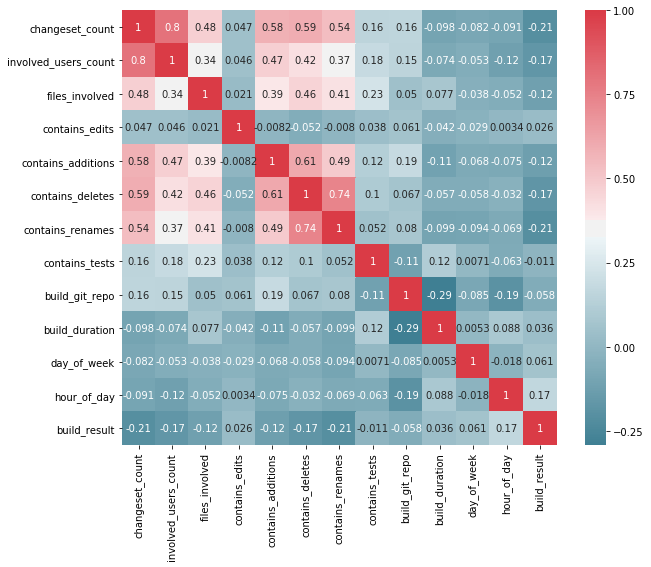

In [26]:
f, ax = plt.subplots(figsize=(10, 8))
corr = userless_df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(
    220, 10, as_cmap=True), square=True, ax=ax, annot=True)

## Check data balance

Checking the balancing of the data.  Do we have enough failed builds?

In [27]:
y = grouped_df.build_result
X = grouped_df.drop('build_result', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)


In [28]:
display(Counter(y_test))

Counter({1: 713, 0: 107})

## Apply logistic regression

In [29]:
from sklearn import linear_model
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
# C = inverse of regularization strength.  Smaller values result in stronger regularization
# Different solvers : https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-defintions
logreg = linear_model.LogisticRegression(C=1, solver='liblinear') 
logreg.fit(X, y)

#print('coefficiënten: ',logreg.coef_)
#print('intercept:',logreg.intercept_)

y_pred = logreg.predict(X_test)
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test,y_pred)*100)
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.17      0.28       107
           1       0.89      0.99      0.94       713

    accuracy                           0.89       820
   macro avg       0.84      0.58      0.61       820
weighted avg       0.87      0.89      0.85       820

88.53658536585365
[[ 18  89]
 [  5 708]]


## Hyper parameter tuning

In [30]:
# Reusable evaluation functions
def SearchHyperParameters(cv_searcher, 
                          X_train, y_train, X_test, y_test, 
                          scoring_parameter, fold_count):

    cv_searcher.scoring = scoring_parameter
    cv_searcher.cv = fold_count
    cv_searcher.n_jobs = -1
    cv_searcher.verbose = 5

    search_model = cv_searcher.fit(X_train, y_train)
    return search_model


In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

logistic_parameters = {'solver': ['newton-cg', 'liblinear', 'saga'],
                        'C': np.linspace(0.01,30,20), # haal C uit een random logaritmische distribution van 20 stappen
                        'class_weight': ['balanced', None]}

fold_count = 6
cv_searcher = GridSearchCV(estimator = logreg, param_grid = logistic_parameters)

best_model = SearchHyperParameters(cv_searcher, X_train, y_train, X_test, y_test, 'accuracy', 10)


Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 850 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  1.1min finished
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [32]:
best_accuracy = best_model.best_score_
best_parameters = best_model.best_params_

print('Best accuracy : ', best_model.best_score_)
print('Best parameters :', best_model.best_params_)

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)
print(cf)
accuracy = accuracy_score(y_test, y_pred) * 100
print(accuracy)

Best accuracy :  0.8820683933338141
Best parameters : {'C': 0.01, 'class_weight': None, 'solver': 'saga'}
              precision    recall  f1-score   support

           0       0.20      0.01      0.02       107
           1       0.87      0.99      0.93       713

    accuracy                           0.87       820
   macro avg       0.53      0.50      0.47       820
weighted avg       0.78      0.87      0.81       820

[[  1 106]
 [  4 709]]
86.58536585365853


### Saving the model to disk

In [33]:
filename = './models/smart-devops-logreg.sav'
pickle.dump(best_model, open(filename, 'wb'))
pickle.dump(best_model.best_params_, open('./models/smart-devops-logreg.par', 'wb'))

## Model execution & prediction

In [35]:
loaded_model = pickle.load(open(filename, 'rb'))

### Function to parse input data

In [36]:
def prepare_data(input_data: pd.DataFrame) -> pd.DataFrame:
    input_data.drop(
    ['DefinitionId', 'DefinitionName', 'DefinitionQueueStatus', 'DefinitionType'], 
    axis=1, inplace=True) 
    
    ## Save cat codes and reload cat codes on parse, as new codes can appear
    input_data.ChangeSetCheckedInBy = pd.Categorical(input_data.ChangeSetCheckedInBy)
    input_data['user'] = input_data.ChangeSetCheckedInBy.cat.codes

    input_data.drop('ChangeSetCheckedInBy', axis=1, inplace=True) 
    
    # Handle timestamps
    input_data['BuildFinishTime'] = pd.to_datetime(input_data['BuildFinishTime']) 
    input_data['BuildQueueTime'] = pd.to_datetime(input_data['BuildQueueTime']) 
    input_data['BuildStartTime'] = pd.to_datetime(input_data['BuildStartTime']) 

    # Set properties
    input_data['changeset_isedit'] = input_data['ChangeSetChangeChangeType'].apply(
        lambda ct: 1 if (str(ct).lower().find("edit") > -1) else 0)
    input_data['changeset_isadd'] = input_data['ChangeSetChangeChangeType'].apply(
        lambda ct: 1 if (str(ct).lower().find("add") > -1) else 0)
    input_data['changeset_isdelete'] = input_data['ChangeSetChangeChangeType'].apply(
        lambda ct: 1 if (str(ct).lower().find("delete") > -1) else 0)
    input_data['changeset_isrename'] = input_data['ChangeSetChangeChangeType'].apply(
        lambda ct: 1 if (str(ct).lower().find("rename") > -1) else 0)
    input_data['changeset_involves_test'] = input_data['ChangeSetChangeFile'].apply(
        lambda ct: 1 if (str(ct).lower().find("test") > -1) else 0)
    
    input_data = OneHotEncode(input_data, 'user')
    
    input_data['BuildGitRepo'] = input_data['BuildRepositoryType'].apply(
        lambda repotype: 1 if (str(repotype).lower().find("git") > -1) else 0)
    input_data.drop('BuildRepositoryType', axis=1, inplace=True) 

    input_data['BuildDuration'] = input_data.apply(
        lambda row: (row['BuildFinishTime'] - row['BuildStartTime']).total_seconds(), axis=1)
    input_data['DayOfWeek'] = input_data.BuildFinishTime.dt.dayofweek
    input_data['HourOfDay'] = input_data.BuildFinishTime.dt.hour

    input_data.drop(
        ['BuildFinishTime', 'BuildStartTime', 'BuildQueueTime'], 
        axis=1, inplace=True) 
    
    print(Counter(input_data['BuildId']))

    _grouped_df = input_data.groupby('BuildId')
    _grouped_df = _grouped_df.apply(apply_build_group_logic)
    
    _grouped_df = _grouped_df.fillna(0)
    
    return _grouped_df


### Load test file and predict

In [39]:
test_build = pd.read_csv('data/smart-devops-test.csv', delimiter=';')
print('Number of changeset records: ', len(test_build))
test_build.head(3)
input_vals = prepare_data(test_build)
input_vals.head()
#print('Number of test inputs', len(input_vals))

Number of changeset records:  131
Counter({14171: 131})


,,changeset_count,involved_users_count,files_involved,contains_edits,contains_additions,contains_deletes,contains_renames,contains_tests,build_git_repo,build_duration,...,user_31,user_32,user_33,user_34,user_35,user_36,user_37,user_38,user_39,user_40
BuildId,,,,,,,,,,,,,,,,,,,,,,
14171,0,50,5,26,1,1,0,0,0,1,104.0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
input_pred = best_model.predict(input_vals)

In [43]:
print(input_pred)

[1]


# RandomForestClassifier & Decision tree

In [66]:
def PickMostSignificantFeatures(full_dataset, model, feature_count, debug = False):
    important_features = pd.DataFrame({'feature': full_dataset.columns, 'importance': model.feature_importances_}
             ).sort_values('importance', ascending=False).head(feature_count)
    if(debug):
        print(feature_count, 'Most important features:', important_features)
    return important_features

def ValidateBinaryClassifier(fitted_model, X_test, y_test, show_roc:bool=True):
    y_pred = fitted_model.predict(X_test)
    print(classification_report(y_test,y_pred))
    print(confusion_matrix(y_test,y_pred))
    print(f'Accuracy: {"{:.4%}".format(accuracy_score(y_test,y_pred))}')
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    print(f'ROC: Area under the curve: {"{:.4%}".format(roc_auc)}')
    if show_roc:
        # Plot ROC curve
        import matplotlib.pyplot as plt
        plt.title('ROC')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

In [47]:
hyper_parameters = {
    'n_estimators': [10, 100, 1000],
    'max_depth': [4, 10, 12]
}

model = RandomForestClassifier()

cv_searcher = RandomizedSearchCV(model, hyper_parameters)
cv_searcher.scoring = 'accuracy' #f1 score could be used too
cv_searcher.cv = 10 # k-fold 
cv_searcher.verbose = 1

selected_model = cv_searcher.fit(X_train, y_train)
best_accuracy = selected_model.best_score_ 
best_parameters = selected_model.best_params_ 
print('Best hyper parameters found:', best_parameters)
print('Best accuracy:', best_accuracy)

#model_fit = TuneParameters(model, hyper_parameters,
#                           PickMostSignificantFeatures(pd.DataFrame(X_train, columns=X.columns), rft_model_fit.best_estimator_, 5), y_train, 4)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   43.2s finished


Best hyper parameters found: {'n_estimators': 1000, 'max_depth': 12}
Best accuracy: 0.9350082966596925


In [54]:
important_features = PickMostSignificantFeatures(X, selected_model.best_estimator_, 10, False)
print(important_features)

                 feature  importance
9         build_duration    0.302363
11           hour_of_day    0.109062
2         files_involved    0.067158
0        changeset_count    0.063415
38               user_26    0.059868
40               user_28    0.044527
1   involved_users_count    0.030011
10           day_of_week    0.027369
26               user_14    0.022664
45               user_33    0.021329


              precision    recall  f1-score   support

           0       0.93      0.50      0.65       107
           1       0.93      0.99      0.96       713

    accuracy                           0.93       820
   macro avg       0.93      0.75      0.81       820
weighted avg       0.93      0.93      0.92       820

[[ 54  53]
 [  4 709]]
Accuracy: 93.0488%
ROC: Area under the curve: 74.9531%


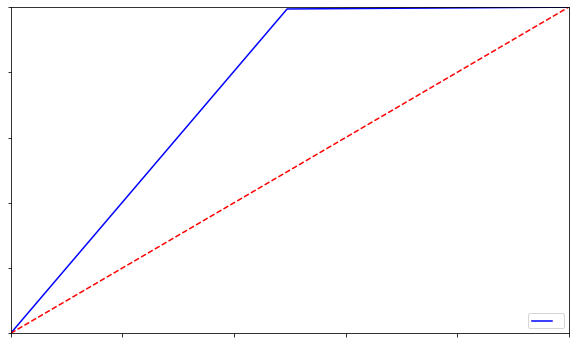

In [70]:
ValidateBinaryClassifier(selected_model.best_estimator_, X_test, y_test)